In [56]:
#Data Preprocessing
import pandas as pd
import numpy as np
import ssl
import nltk

# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Now try downloading again
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from textblob import TextBlob

#Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

#Model
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lucanyckees/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucanyckees/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [66]:
df = pd.read_csv('../data/amazon.csv')
pd.set_option('display.max_colwidth', 60)
df = df.drop_duplicates()

# Convert 'discounted_price' and 'actual_price' by removing currency symbol and converting to float
df['discounted_price'] = df['discounted_price'].astype(str).str.replace('₹', '').str.replace(',', '').astype(float)
df['actual_price'] = df['actual_price'].astype(str).str.replace('₹', '').str.replace(',', '').astype(float)

# Convert 'discount_percentage' by removing '%' and converting to float
df['discount_percentage'] = df['discount_percentage'].astype(str).str.replace('%', '').astype(float)

# Convert 'rating' to float
df['rating'] = pd.to_numeric(df['rating'].astype(str).str.replace('|', ''), errors='coerce')

# Convert 'rating_count' by removing commas and converting to int

In [67]:
df['rating_count'] = df['rating_count'].astype(str).str.replace(',', '')
df = df.loc[df['rating_count'] != 'nan'].copy()
df['rating_count'] = df['rating_count'].astype(int)

In [68]:
# Cleaning and preprocessing text without lemmatization
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Split text into words and rejoin without stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Assuming df is your DataFrame and it has been previously loaded
# Apply the clean_text function to the DataFrame columns
df['product_name'] = df['product_name'].apply(clean_text)
df['about_product'] = df['about_product'].apply(clean_text)
df['review_content'] = df['review_content'].apply(clean_text)
df['category'] = df['category'].apply(clean_text)

In [69]:
#Extracting the top-level category
df['category'] = df['category'].apply(lambda x: x.split('|')[0] if pd.notnull(x) else x)

In [70]:
unique_products_count = df['product_id'].nunique()
average_price = df['actual_price'].mean()
best_selling_product = df.loc[df['rating_count'].idxmax()]
least_selling_product = df.loc[df['rating_count'].idxmin()]
top_rated_product = df.loc[df['rating'].idxmax()]
lowest_rated_product = df.loc[df['rating'].idxmin()]
most_expensive_product = df.loc[df['actual_price'].idxmax()]
cheapest_product = df.loc[df['actual_price'].idxmin()]
highest_discount_product = df.loc[df['discount_percentage'].idxmax()]
avg_rating_count = df.groupby('product_id')['rating_count'].mean().mean()

In [71]:
df_anl = pd.DataFrame({
    'Question': [
        'Number of Unique Products',
        'Average Price',
        'Best-selling Product',
        'Least-selling Product',
        'Top-rated Product',
        'Lowest-rated Product',
        'Most Expensive Product',
        'Cheapest Product',
        'Highest Discount Product',
        'Average Rating Count for Each Product'
    ],
    'Answer': [
        unique_products_count,
        average_price,
        best_selling_product['product_name'],
        least_selling_product['product_name'],
        top_rated_product['product_name'],
        lowest_rated_product['product_name'],
        most_expensive_product['product_name'],
        cheapest_product['product_name'],
        highest_discount_product['product_name'],
        avg_rating_count
    ],
    'Actual Price': [
        None,
        None,
        best_selling_product['actual_price'],
        least_selling_product['actual_price'],
        top_rated_product['actual_price'],
        lowest_rated_product['actual_price'],
        most_expensive_product['actual_price'],
        cheapest_product['actual_price'],
        highest_discount_product['actual_price'],
        None
    ]
})

df_anl

,Question,Answer,Actual Price
0,Number of Unique Products,1349,NaN
1,Average Price,5451.068544,NaN
2,Best-selling Product,amazonbasics flexible premium hdmi cable black 4k60hz 18...,700.0
3,Least-selling Product,khaitan orfin fan heater home kitchenk0 2215,2495.0
4,Top-rated Product,syncwire ltg usb cable fast charging compatible phone 5 ...,1999.0
5,Lowest-rated Product,khaitan orfin fan heater home kitchenk0 2215,2495.0
6,Most Expensive Product,sony bravia 164 cm 65 inches 4k ultra hd smart led googl...,139900.0
7,Cheapest Product,ecosmos 5v 12w portable flexible usb led light colours m...,39.0
8,Highest Discount Product,rts 2 pack mini usb c type c adapter plug type c female ...,4999.0
9,Average Rating Count for Each Product,17644.501853,NaN


In [72]:
# Sorting the data by rating_count in descending order
top_selling_products = df.sort_values(by='rating_count', ascending=False).head(10)

# Selecting relevant columns for display
top_selling_products = top_selling_products[['product_name', 'rating', 'rating_count']]
top_selling_products.reset_index(drop=True, inplace=True)
top_selling_products

,product_name,rating,rating_count
0,amazonbasics flexible premium hdmi cable black 4k60hz 18...,4.4,426973
1,amazon basics highspeed hdmi cable 6 feet 2packblack,4.4,426973
2,amazon basics highspeed hdmi cable 6 feet supports ether...,4.4,426973
3,amazonbasics flexible premium hdmi cable black 4k60hz 18...,4.4,426972
4,boat bassheads 100 ear wired earphones micfurious red,4.1,363713
5,boat bassheads 100 ear wired earphones mictaffy pink,4.1,363713
6,boat bassheads 100 inear wired headphones mic black,4.1,363711
7,redmi 9 activ carbon black 4gb ram 64gb storage octacore...,4.1,313836
8,redmi 9a sport coral green 2gb ram 32gb storage 2ghz oct...,4.1,313836
9,redmi 9a sport carbon black 2gb ram 32gb storage 2ghz oc...,4.1,313832


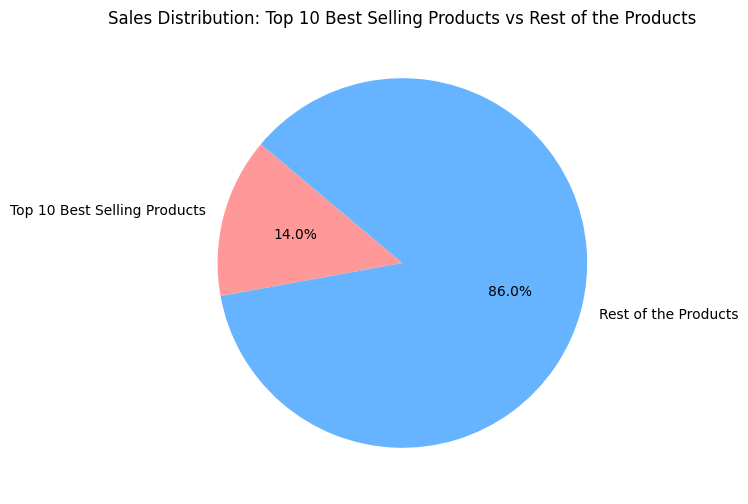

In [73]:
top_10_total_ratings = top_selling_products['rating_count'].sum()
total_ratings_all_products = df['rating_count'].sum()
ratings_rest_of_products = total_ratings_all_products - top_10_total_ratings
pie_data = [top_10_total_ratings, ratings_rest_of_products]
labels = ['Top 10 Best Selling Products', 'Rest of the Products']

# Creating the pie chart
plt.figure(figsize=(10, 6))
plt.pie(pie_data, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Sales Distribution: Top 10 Best Selling Products vs Rest of the Products')
plt.show()

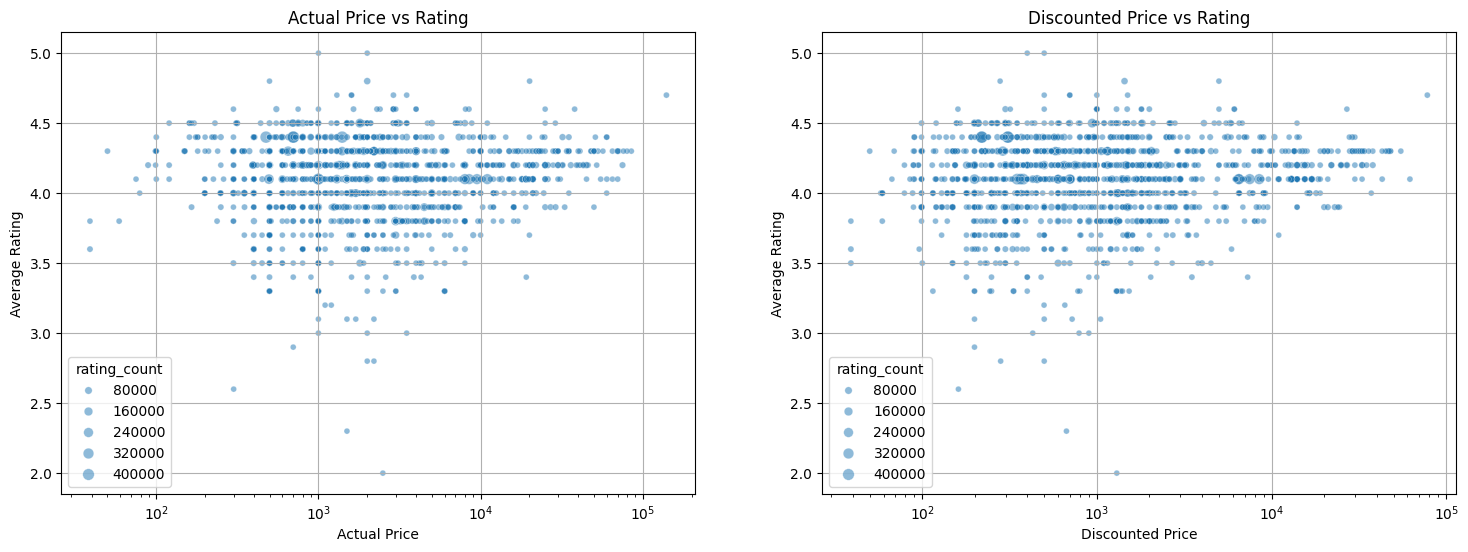

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#Scatter plot for actual price vs rating
sns.scatterplot(ax=axes[0], data=df, x='actual_price', y='rating', size='rating_count', alpha=0.5)
axes[0].set_title('Actual Price vs Rating')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Average Rating')
axes[0].set_xscale('log')
axes[0].grid(True)

#Scatter plot for discounted price vs rating
sns.scatterplot(ax=axes[1], data=df, x='discounted_price', y='rating', size='rating_count', alpha=0.5)
axes[1].set_title('Discounted Price vs Rating')
axes[1].set_xlabel('Discounted Price')
axes[1].set_ylabel('Average Rating')
axes[1].set_xscale('log')  
axes[1].grid(True)

plt.show()

In [75]:
categories = df['category'].str.split('|').explode()
category_counts = Counter(categories)
category_df = pd.DataFrame(category_counts.items(), columns=['Category', 'Count']).sort_values(by='Count', ascending=False)

#Display the top categories
top_categories = category_df.head(10)
top_categories.reset_index(drop=True, inplace=True)
top_categories

,Category,Count
0,computersaccessoriesaccessoriesperipheralscablesaccessor...,231
1,electronicswearabletechnologysmartwatches,76
2,electronicsmobilesaccessoriessmartphonesbasicmobilessmar...,68
3,electronicshometheatertvvideotelevisionssmarttelevisions,63
4,electronicsheadphonesearbudsaccessoriesheadphonesinear,52
5,electronicshometheatertvvideoaccessoriesremotecontrols,49
6,homekitchenkitchenhomeappliancessmallkitchenappliancesmi...,27
7,electronicshometheatertvvideoaccessoriescableshdmicables,24
8,homekitchenkitchenhomeappliancesvacuumcleaningironingiro...,24
9,computersaccessoriesaccessoriesperipheralskeyboardsmicei...,24


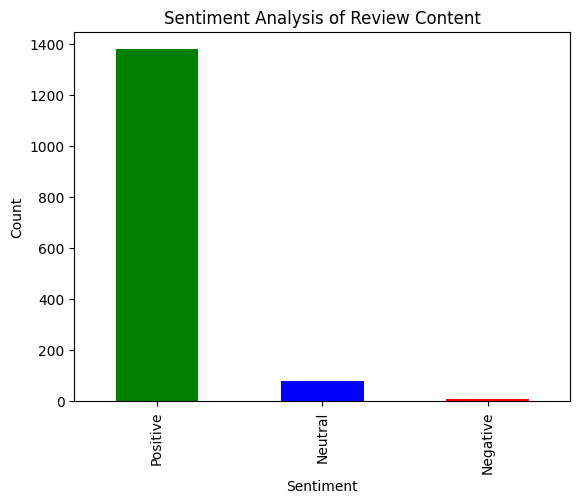

In [76]:
#Classify sentiment
def sentiment_analysis(text):
    analysis = TextBlob(text)
    #threshold for positive and negative sentiments
    if analysis.sentiment.polarity > 0.1:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

#Applying sentiment analysis to the review content
reviews = df['review_content'] 
reviews_sentiments = reviews.apply(sentiment_analysis)

# Counting the occurrences of each sentiment
sentiment_counts = reviews_sentiments.value_counts()

sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'], title='Sentiment Analysis of Review Content')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [77]:
# Adding the sentiment labels back to the reviews
df['Sentiment'] = reviews_sentiments

# Finding examples of positive, neutral, and negative sentiments
positive_example = df[df['Sentiment'] == 'Positive'].iloc[0]['review_content']
neutral_example = df[df['Sentiment'] == 'Neutral'].iloc[0]['review_content']
negative_example = df[df['Sentiment'] == 'Negative'].iloc[0]['review_content']

print("Example of sentiment review: ")
example_reviews = pd.DataFrame({
    "Sentiment": ["Positive", "Neutral", "Negative"],
    "Review": [positive_example, neutral_example, negative_example]
})
example_reviews

Example of sentiment review: 


,Sentiment,Review
0,Positive,looks durable charging fine toono complainscharging real...
1,Neutral,overall goodtv picture ok smart bettersound low another ...
2,Negative,value moneyusually gdgood productgoodquality poor respon...


In [78]:
drop_col = ['discounted_price', 'actual_price', 'discount_percentage', 'review_id', 'review_title',
                   'user_name', 'img_link', 'product_link']
df = df.drop(columns=drop_col)

In [79]:
df['combined_text'] = df['product_name'] + ' ' + df['category'] + ' ' + df['about_product'] +' '+ df['review_content']
#Fill null with empty string to avoid issues
df['combined_text'] = df['combined_text'].fillna('')

#Instantiate TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2, ngram_range=(1, 1))

#Fit and transform
tfidf_matrix = vectorizer.fit_transform(df['combined_text'])

In [80]:
label_encoder = LabelEncoder()

# Fitting the encoder and transforming the 'Sentiment' column
df['Encoded_Sentiment'] = label_encoder.fit_transform(df['Sentiment'])

In [93]:
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 201918 stored elements and shape (1463, 13505)>

In [94]:
# Compute the cosine similarity matrix based on the tfidf_matrix
cosine_sim = cosine_similarity(tfidf_matrix)

# Print the shape of the cosine similarity matrix to verify
cosine_sim.shape

(1463, 1463)

In [95]:
# Create a product-user matrix with overall product ratings
product_user_matrix = df.pivot_table(index='product_id', values='rating', aggfunc='mean')

#Fill missing values with the average rating
product_user_matrix = product_user_matrix.fillna(product_user_matrix.mean())

#Display the product-user matrix
product_user_matrix.head()

,rating
product_id,
B002PD61Y4,4.1
B002SZEOLG,4.2
B003B00484,4.3
B003L62T7W,4.3
B004IO5BMQ,4.5


In [98]:
def hybrid_recommendation(product_id, content_sim_matrix, product_user_matrix, products, top_n=10):
    #Get the index of the product that matches the product_id
    idx = products.index[products['product_id'] == product_id][0]

    #Content-based filtering
    #Get pairwise similarity scores
    sim_scores = list(enumerate(content_sim_matrix[idx]))
    #Sort the products based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #Get the scores of the top N most similar products
    content_recommendations_idx = [i[0] for i in sim_scores[1:top_n+1]]

    #Collaborative Filtering
    #Get the rating of the current product
    if product_id in product_user_matrix.index:
        current_product_rating = product_user_matrix.loc[product_id].values[0]
        # Find products with similar ratings
        similar_rating_products = product_user_matrix.iloc[(product_user_matrix['rating']-current_product_rating).abs().argsort()[:top_n]]

    #Combine content and collaborative recommendations
    #Get indices for collaborative recommendations
    collaborative_recommendations_idx = similar_rating_products.index
    #Map indices to product IDs
    collaborative_recommendations_idx = [products.index[products['product_id'] == pid].tolist()[0] for pid in collaborative_recommendations_idx]

    #Combine indices from both methods and remove duplicates
    combined_indices = list(set(content_recommendations_idx + collaborative_recommendations_idx))

    #Get recommended products details
    recommended_products = products.iloc[combined_indices].copy()
    recommended_products = recommended_products[['product_id', 'product_name', 'rating']]
    
    return recommended_products

In [99]:
sample_product_id = df['product_id'][0]
sample_product_name = df['product_name'][0]
recommended_products = hybrid_recommendation(sample_product_id, cosine_sim, product_user_matrix, df)
print("Recommendation for user who purchased product \"" + sample_product_name + "\"")
recommended_products.head(10)

Recommendation for user who purchased product "wayona nylon braided usb lightning fast charging data sync cable compatible iphone 13 1211 x 8 7 6 5 ipad air pro mini 3 ft pack 1 grey"


,product_id,product_name,rating
1158,B0BMTZ4T1D,1000 watt2000watt room heater fan heaterpure whitehn2500...,4.5
261,B07F1P8KNV,wayona nylon braided usb type c 3ft 1m 3a fast charger c...,4.2
1417,B09HS1NDRQ,prettykrafts laundry square shape basket bagfoldablemult...,3.8
11,B0789LZTCJ,boat rugged v3 extra tough unbreakable braided micro usb...,4.2
785,B098R25TGC,noise buds vs201 v2 inear truly wireless earbuds dual eq...,3.8
274,B075TJHWVC,airtel digital tv hd set top box 1 month basic pack reco...,4.2
166,B07JPJJZ2H,wayona nylon braided lightning usb data sync 3a charging...,4.2
42,B07JW1Y6XV,wayona nylon braided 3a lightning usb syncing fast charg...,4.2
1204,B09KPXTZXN,rico japanese technology rechargeable wireless electric ...,4.0
1332,B0B9RZ4G4W,amazon basics 300 w hand blender stainless steel stem ho...,4.0
